In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I have always admired Susan Sarandon for her integrity and honesty in her private life as well as her talents as an actor. I therefor found it strange that she would appear in a film that so distorted that facts. Her character's rescue from the South Pole was done by a Canadian charter company from Edmonton, Alberta flying a Canadian designed and built Twin Otter aircraft. The trip had been turned down by the US Airforce, Navy and Coast Guard as beyond their capabilities. The same company staged a similar rescue a few years later to bring out a man from the South Pole base. I feel that the film fairly represented a very gripping subject and documented a very courageous woman facing a frightening task. I fail to see why the producers would find it necessary ignore the bravery of the rescue pilots and show the rescue plane as a USAF Hercules."
 b"Documentaries of this kind are often very opinionated. This film seems to take all opinions out and let the viewer decide what to do

### Buat Teks Encoder

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10,  26, 203, ...,   0,   0,   0],
       [  1,   5,  11, ...,   0,   0,   0],
       [  1,   7,   4, ...,   0,   0,   0]])

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I have always admired Susan Sarandon for her integrity and honesty in her private life as well as her talents as an actor. I therefor found it strange that she would appear in a film that so distorted that facts. Her character's rescue from the South Pole was done by a Canadian charter company from Edmonton, Alberta flying a Canadian designed and built Twin Otter aircraft. The trip had been turned down by the US Airforce, Navy and Coast Guard as beyond their capabilities. The same company staged a similar rescue a few years later to bring out a man from the South Pole base. I feel that the film fairly represented a very gripping subject and documented a very courageous woman facing a frightening task. I fail to see why the producers would find it necessary ignore the bravery of the rescue pilots and show the rescue plane as a USAF Hercules."
Round-trip:  i have always [UNK] [UNK] [UNK] for her [UNK] and [UNK] in her [UNK] life as well as her [UNK] as an actor i [UNK] found

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[-0.00526267]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 359ms/step
[-0.00526267]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Train Model

In [ ]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 636s 2s/step - loss: 0.6517 - accuracy: 0.5688 - val_loss: 0.5390 - val_accuracy: 0.7391
Epoch 2/10
391/391 [==============================] - 621s 2s/step - loss: 0.4548 - accuracy: 0.7871 - val_loss: 0.3922 - val_accuracy: 0.8151
Epoch 3/10
391/391 [==============================] - 606s 2s/step - loss: 0.3599 - accuracy: 0.8374 - val_loss: 0.3487 - val_accuracy: 0.8542
Epoch 4/10
391/391 [==============================] - 614s 2s/step - loss: 0.3309 - accuracy: 0.8536 - val_loss: 0.3322 - val_accuracy: 0.8594
Epoch 5/10
391/391 [==============================] - 585s 1s/step - loss: 0.3162 - accuracy: 0.8621 - val_loss: 0.3340 - val_accuracy: 0.8641
Epoch 6/10
391/391 [==============================] - 609s 2s/step - loss: 0.3069 - accuracy: 0.8686 - val_loss: 0.3250 - val_accuracy: 0.8474
Epoch 7/10
391/391 [==============================] - 589s 2s/step - loss: 0.3053 - accuracy: 0.8684 - val_loss: 0.3202 - val_accuracy: 0.8599

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 145s 368ms/step - loss: 0.3226 - accuracy: 0.8640
Test Loss: 0.3225862383842468
Test Accuracy: 0.8639600276947021


(0.0, 0.6695307955145836)

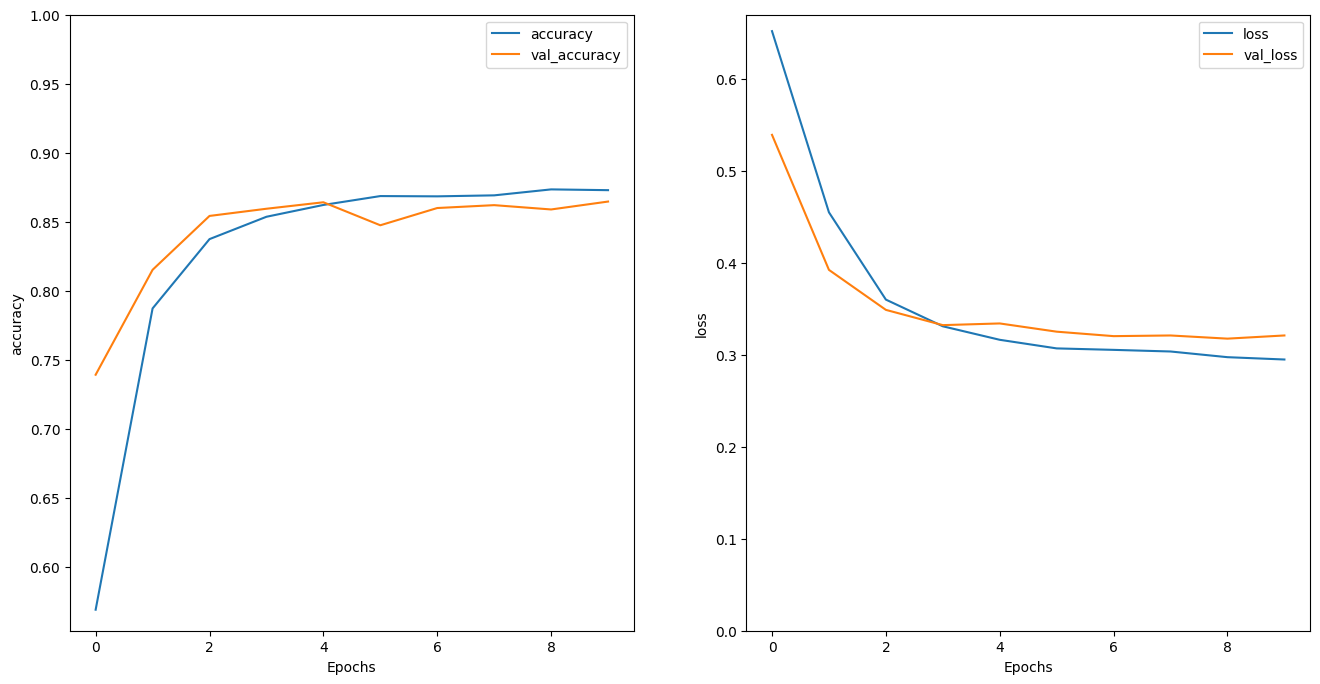

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
              'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


### Stack two or more LSTM layers

In [15]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [18]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1342s 3s/step - loss: 0.6132 - accuracy: 0.5946 - val_loss: 0.4250 - val_accuracy: 0.8031
Epoch 2/10
391/391 [==============================] - 1353s 3s/step - loss: 0.3874 - accuracy: 0.8325 - val_loss: 0.3639 - val_accuracy: 0.8505
Epoch 3/10
391/391 [==============================] - 1330s 3s/step - loss: 0.3424 - accuracy: 0.8541 - val_loss: 0.3337 - val_accuracy: 0.8521
Epoch 4/10
391/391 [==============================] - 1360s 3s/step - loss: 0.3253 - accuracy: 0.8604 - val_loss: 0.3315 - val_accuracy: 0.8599
Epoch 5/10
391/391 [==============================] - 1366s 3s/step - loss: 0.3158 - accuracy: 0.8637 - val_loss: 0.3183 - val_accuracy: 0.8609
Epoch 6/10
391/391 [==============================] - 1337s 3s/step - loss: 0.3088 - accuracy: 0.8694 - val_loss: 0.3193 - val_accuracy: 0.8536
Epoch 7/10
391/391 [==============================] - 1334s 3s/step - loss: 0.3026 - accuracy: 0.8708 - val_loss: 0.3191 - val_accuracy:

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 293s 750ms/step - loss: 0.3196 - accuracy: 0.8617
Test Loss: 0.3195597231388092
Test Accuracy: 0.8617200255393982


In [20]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
              'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-2.0033648]]


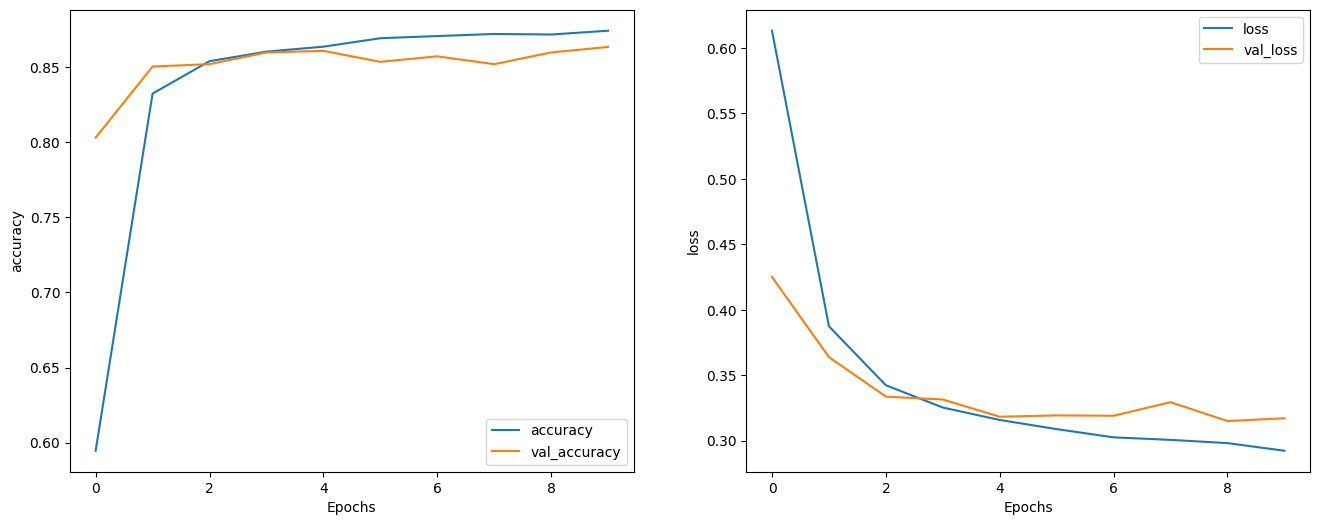

In [21]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')